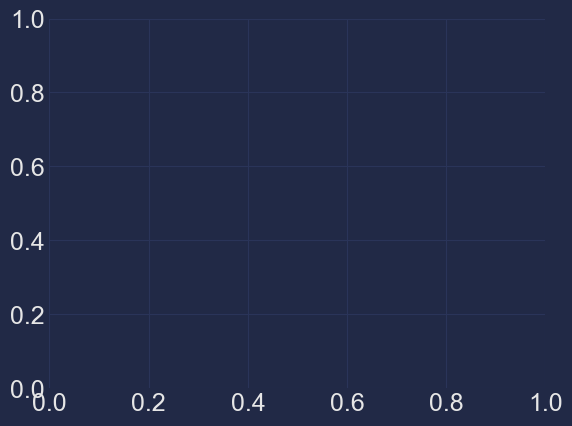

In [136]:
import datetime
import pytz

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import mplcyberpunk

from pathlib import Path
import pandas as pd
import numpy as np
from astropy.io import fits
import astropy.wcs as fitswcs
import astropy.units as u
from astropy.coordinates import EarthLocation, SkyCoord, AltAz, get_moon, Angle
from astropy.time import Time
from astropy.table import Table
import astroplan
from specutils.spectra.spectrum1d import Spectrum1D
from astropy.visualization import (MinMaxInterval, SqrtStretch, ZScaleInterval,
                                   ImageNormalize, quantity_support)
from specutils.manipulation import FluxConservingResampler

from sklearn.decomposition import PCA

_ = quantity_support()
plt.style.use("cyberpunk")
SMALL_SIZE = 18
MEDIUM_SIZE = 20
BIGGER_SIZE = 24

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('font', family='serif')
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [30]:
df = pd.read_csv("sky_spectra.csv")
moonfree = df[(df['moon_alt'] < -10) & (df['disperser'] == '270_gpm') & (df['sun_alt'] < -18)]
moonfree

file                   ut  \
1         data/2004.0413/skysub_F2.20.bg_1_comb.fits  2004-04-13T05:53:13   
2         data/2004.0413/skysub_a2034.bg_1_comb.fits  2004-04-13T08:25:25   
4            data/2004.0414/skysub_F2.bg_1_comb.fits  2004-04-14T05:11:49   
5            data/2004.0414/skysub_F2.bg_2_comb.fits  2004-04-14T07:00:59   
6            data/2004.0415/skysub_F2.bg_3_comb.fits  2004-04-15T05:48:01   
...                                              ...                  ...   
4311  data/2022.1128/skysub_RXCJ0736_b22_4_comb.fits  2022-11-28T08:02:53   
4312  data/2022.1128/skysub_RXCJ0736_b22_5_comb.fits  2022-11-28T10:00:40   
4313   data/2022.1128/skysub_mgj0414_mmt_1_comb.fits  2022-11-28T06:02:24   
4315      data/2022.1129/skysub_A1361b22_2_comb.fits  2022-11-29T12:19:52   
4316  data/2022.1129/skysub_RXCJ0736_b22_6_comb.fits  2022-11-29T09:40:41   

        alt      az  sun_alt  sun_az  moon_alt  moon_az  moon_ill disperser  
1     56.71  278.43   -43.72  328.18    -47.97    91.12        38   270_gpm  
2     81.18   75.47   -46.54   22.33    -17.42   107.26        37   270_gpm  
4     65.04  274.96   -38.09  316.97    -65.06    67.04        28   270_gpm  
5     41.07  284.86   -48.40  351.52    -43.32    87.36        27   270_gpm  
6     55.37  278.13   -42.55  327.22    -64.16    53.43        19   270_gpm  
...     ...     ...      ...     ...       ...      ...       ...       ...  
4311  58.70   65.14   -74.53   51.04    -43.80   265.88        25   270_gpm  
4312  80.36   38.96   -51.01   85.23    -67.25   284.62        26   270_gpm  
4313  59.22  144.83   -71.44  299.81    -20.01   252.90        24   270_gpm  
4315  60.53   51.28   -21.75  102.58    -76.61   340.99        38   270_gpm  
4316  77.91   46.81   -55.38   82.18    -50.17   277.25        37   270_gpm  

[2241 rows x 10 columns]

In [31]:
new_disp_grid = np.arange(3850, 6800, 2) * u.AA
fluxcon = FluxConservingResampler()

In [32]:
fluxes = []
for i, r in moonfree.iterrows():
    sp = Spectrum1D.read(r['file'])
    trim_sp = fluxcon(sp, new_disp_grid)
    fluxes.append(trim_sp.flux)

In [33]:
fluxes = np.array(fluxes)
fits.writeto("sky_fluxes_2022.fits", fluxes, overwrite=True)

In [34]:
fluxes = fits.open('sky_fluxes_2022.fits')[0].data

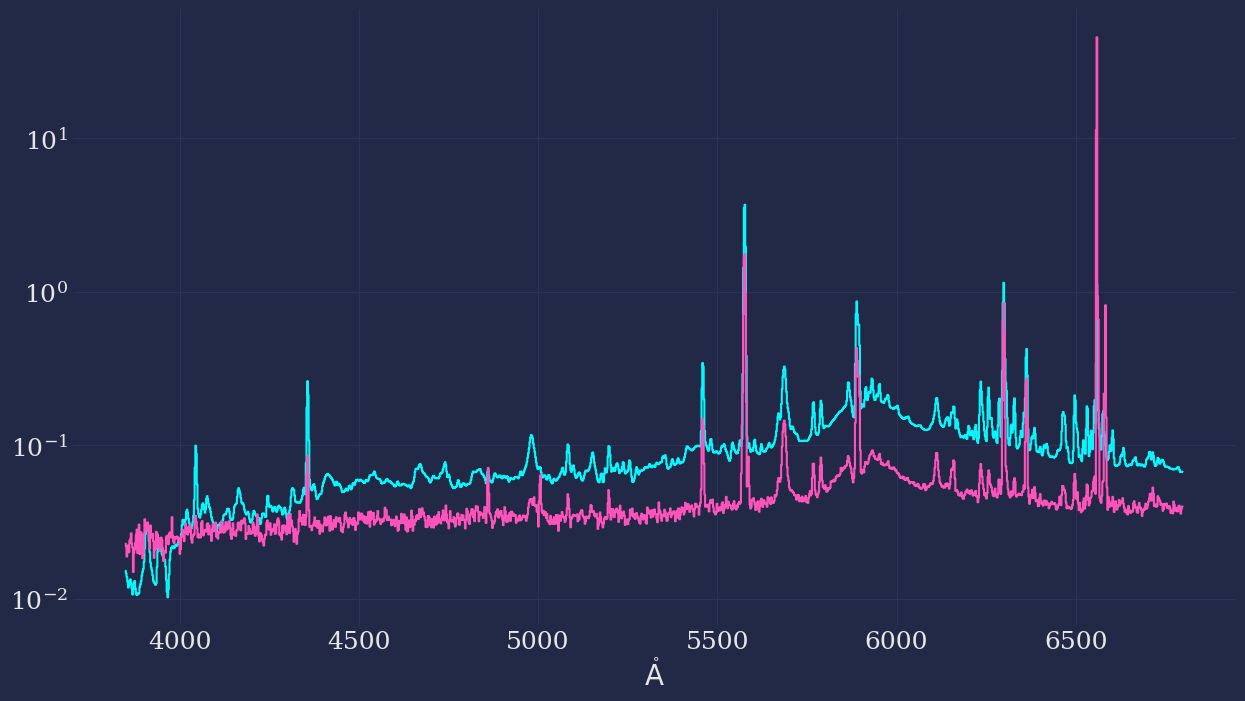

In [35]:
plt.figure(figsize=[15,8])
plt.yscale('log')
plt.step(new_disp_grid, np.mean(fluxes, axis=0))
plt.step(new_disp_grid, np.std(fluxes, axis=0))
plt.show()

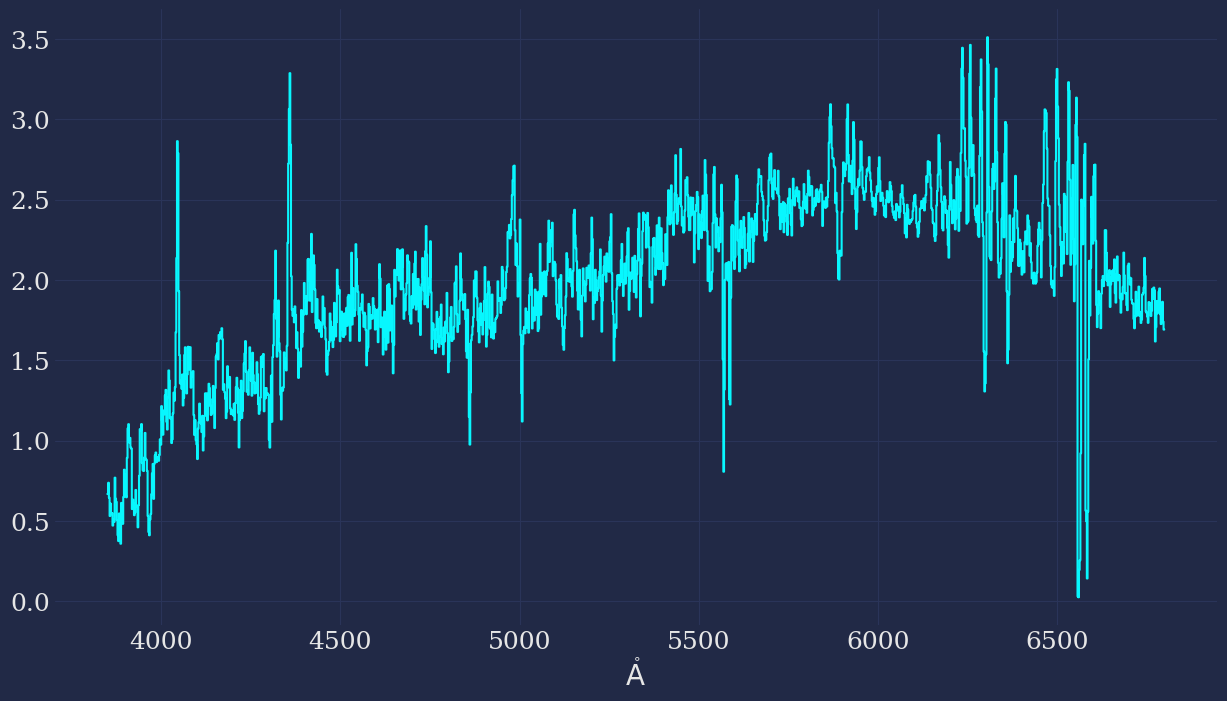

In [36]:
plt.figure(figsize=[15,8])
#plt.yscale('log')
plt.step(new_disp_grid, np.mean(fluxes, axis=0)/np.std(fluxes, axis=0))
plt.show()

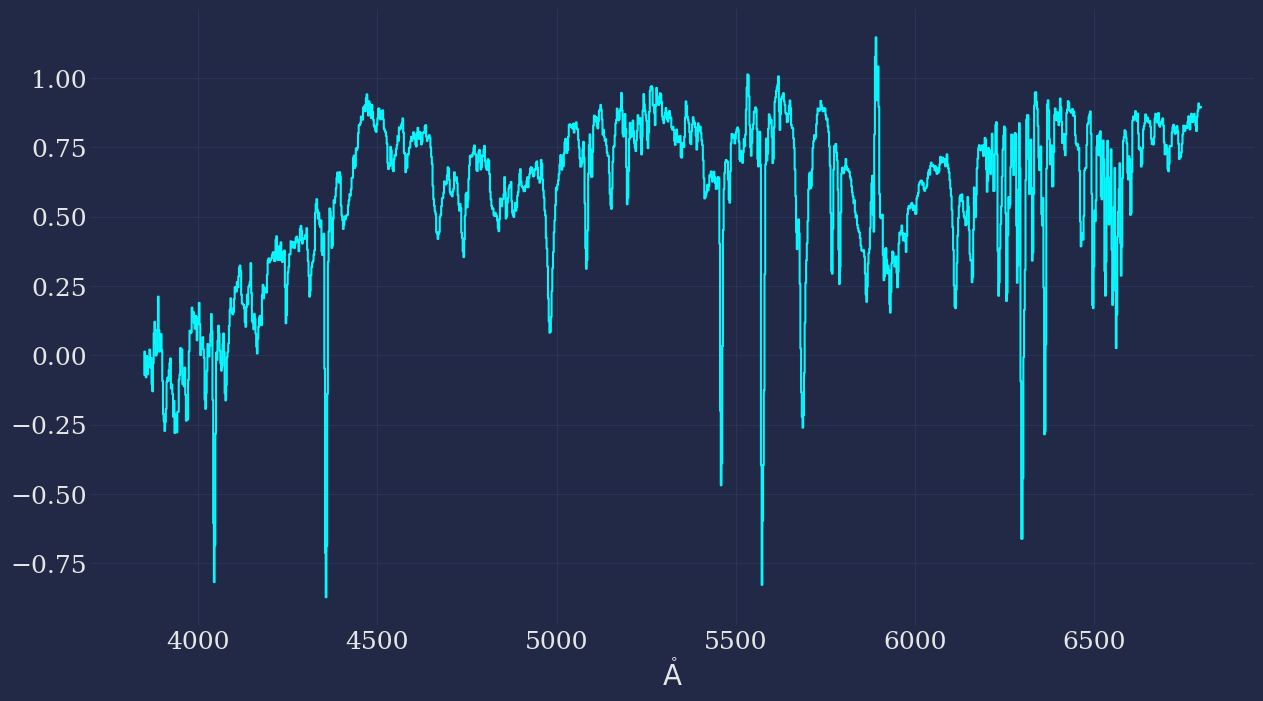

In [37]:
plt.figure(figsize=[15,8])
#plt.yscale('log')
plt.step(new_disp_grid, 2.5 * np.log10(fluxes[-1, :] / fluxes[1200, :]))
plt.show()

In [121]:
pca = PCA(n_components=5).fit(fluxes)

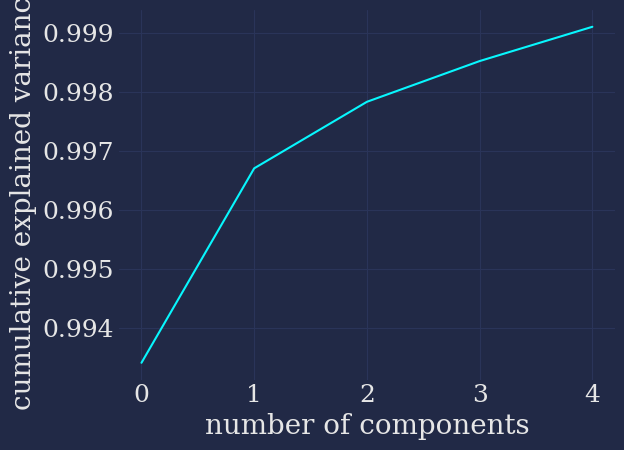

0.9990989237435325

In [122]:
vr = np.cumsum(pca.explained_variance_ratio_)
plt.figure()
plt.plot(vr)
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()
vr[-1]

In [111]:
components = pca.transform(fluxes)
filtered = pca.inverse_transform(components)

In [112]:
components.shape

(2241, 12)

In [113]:
filtered.shape

(2241, 1475)

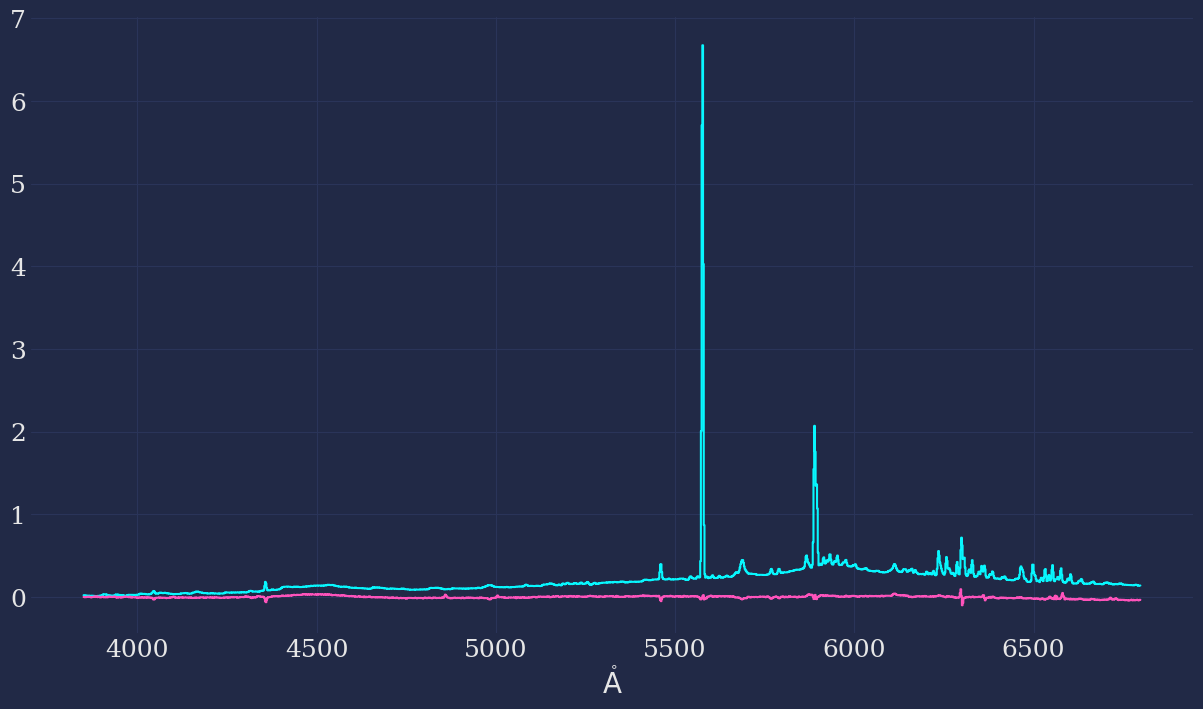

In [123]:
plt.figure(figsize=[15,8])
#plt.yscale('log')
plt.step(new_disp_grid, fluxes[-4, :])
plt.step(new_disp_grid, fluxes[-4, :] - filtered[-4, :])
plt.show()

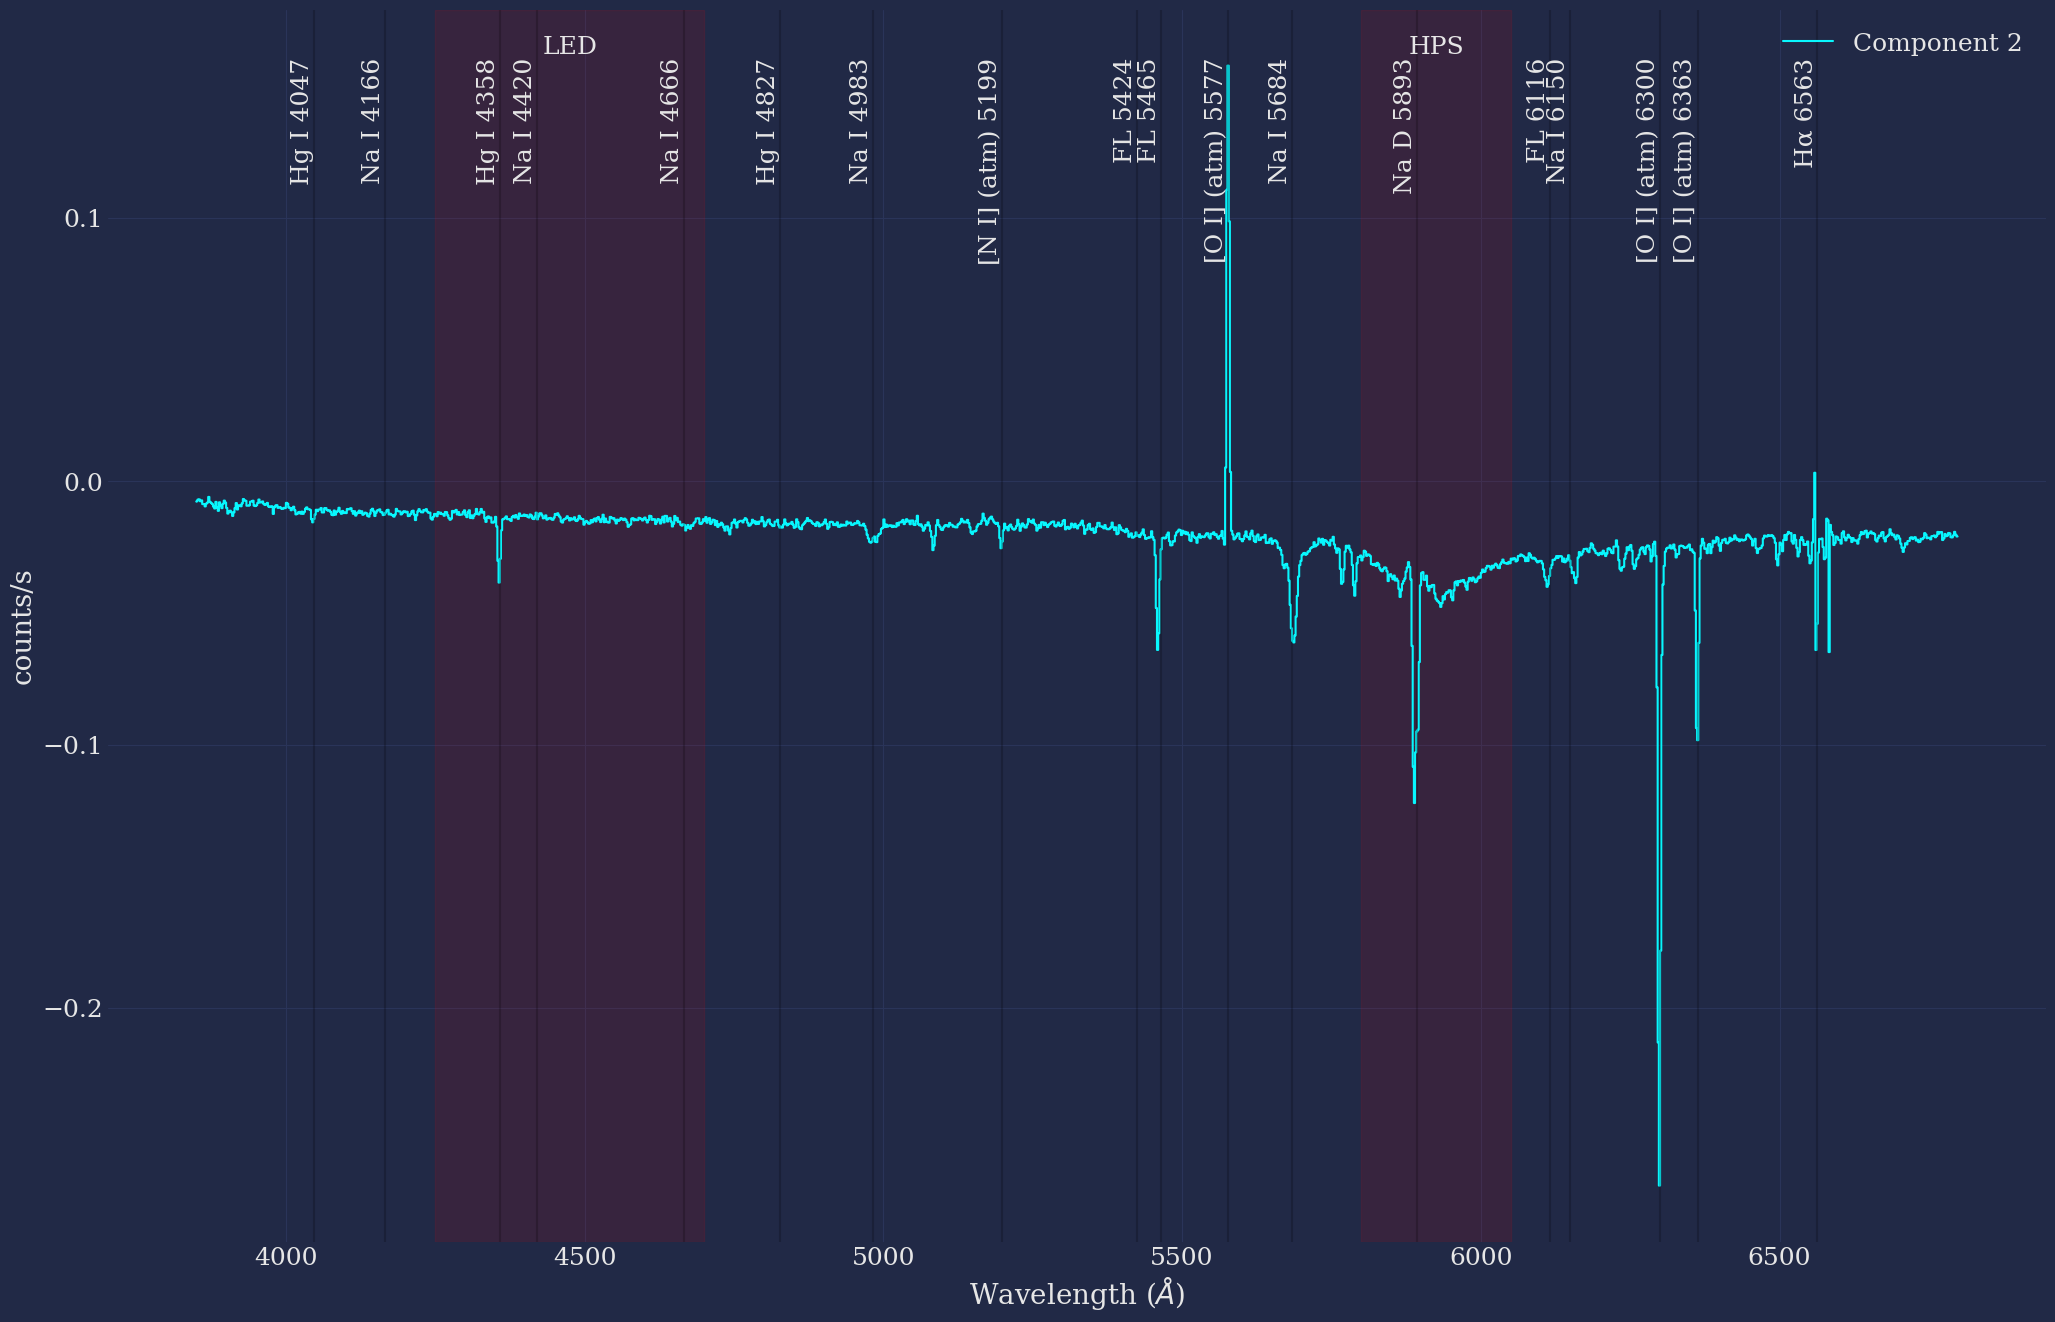

In [130]:
features = Table.read("features.csv")
plt.figure(figsize=[25,16])
#plt.yscale('log')
#for i in range(5):
    #plt.step(new_disp_grid, pca_sm.components_[i], label=f"Component {i}")
i = 2
plt.step(new_disp_grid, pca.components_[i], label=f"Component {i}")
txt_y = 1.02 * np.max(pca.components_[i])
for f in features:
    if f['low wave'] != f['high wave']:
        plt.axvspan(f['low wave'], f['high wave'], color='r', alpha=0.1)
        txt_x = 0.5*(f['low wave'] + f['high wave'])
        plt.text(txt_x, 1.05*txt_y, f['name'], horizontalalignment='center', verticalalignment='top')
    else:
        x = f['low wave']
        plt.text(x, txt_y, f"{f['name']} {x}", rotation='vertical', fontsize='medium', horizontalalignment='right', verticalalignment='top')
        plt.axvline(x, color='black', alpha=0.2)
plt.xlabel("Wavelength ($\AA$)")
plt.ylabel("counts/s")
plt.legend()
plt.show()

In [45]:
components[-1, :]

array([-0.99506226,  0.83467225, -1.05683334,  1.69084912, -0.27300147,
       -0.03237352, -0.21765015, -1.02013906, -0.46392736,  0.3986357 ])

In [46]:
components[0, :]

array([-0.98023798,  1.27795309, -0.58833595,  0.62737235, -0.14710574,
        0.00465107, -0.66092924,  0.71523487, -0.36704563,  0.03826346])

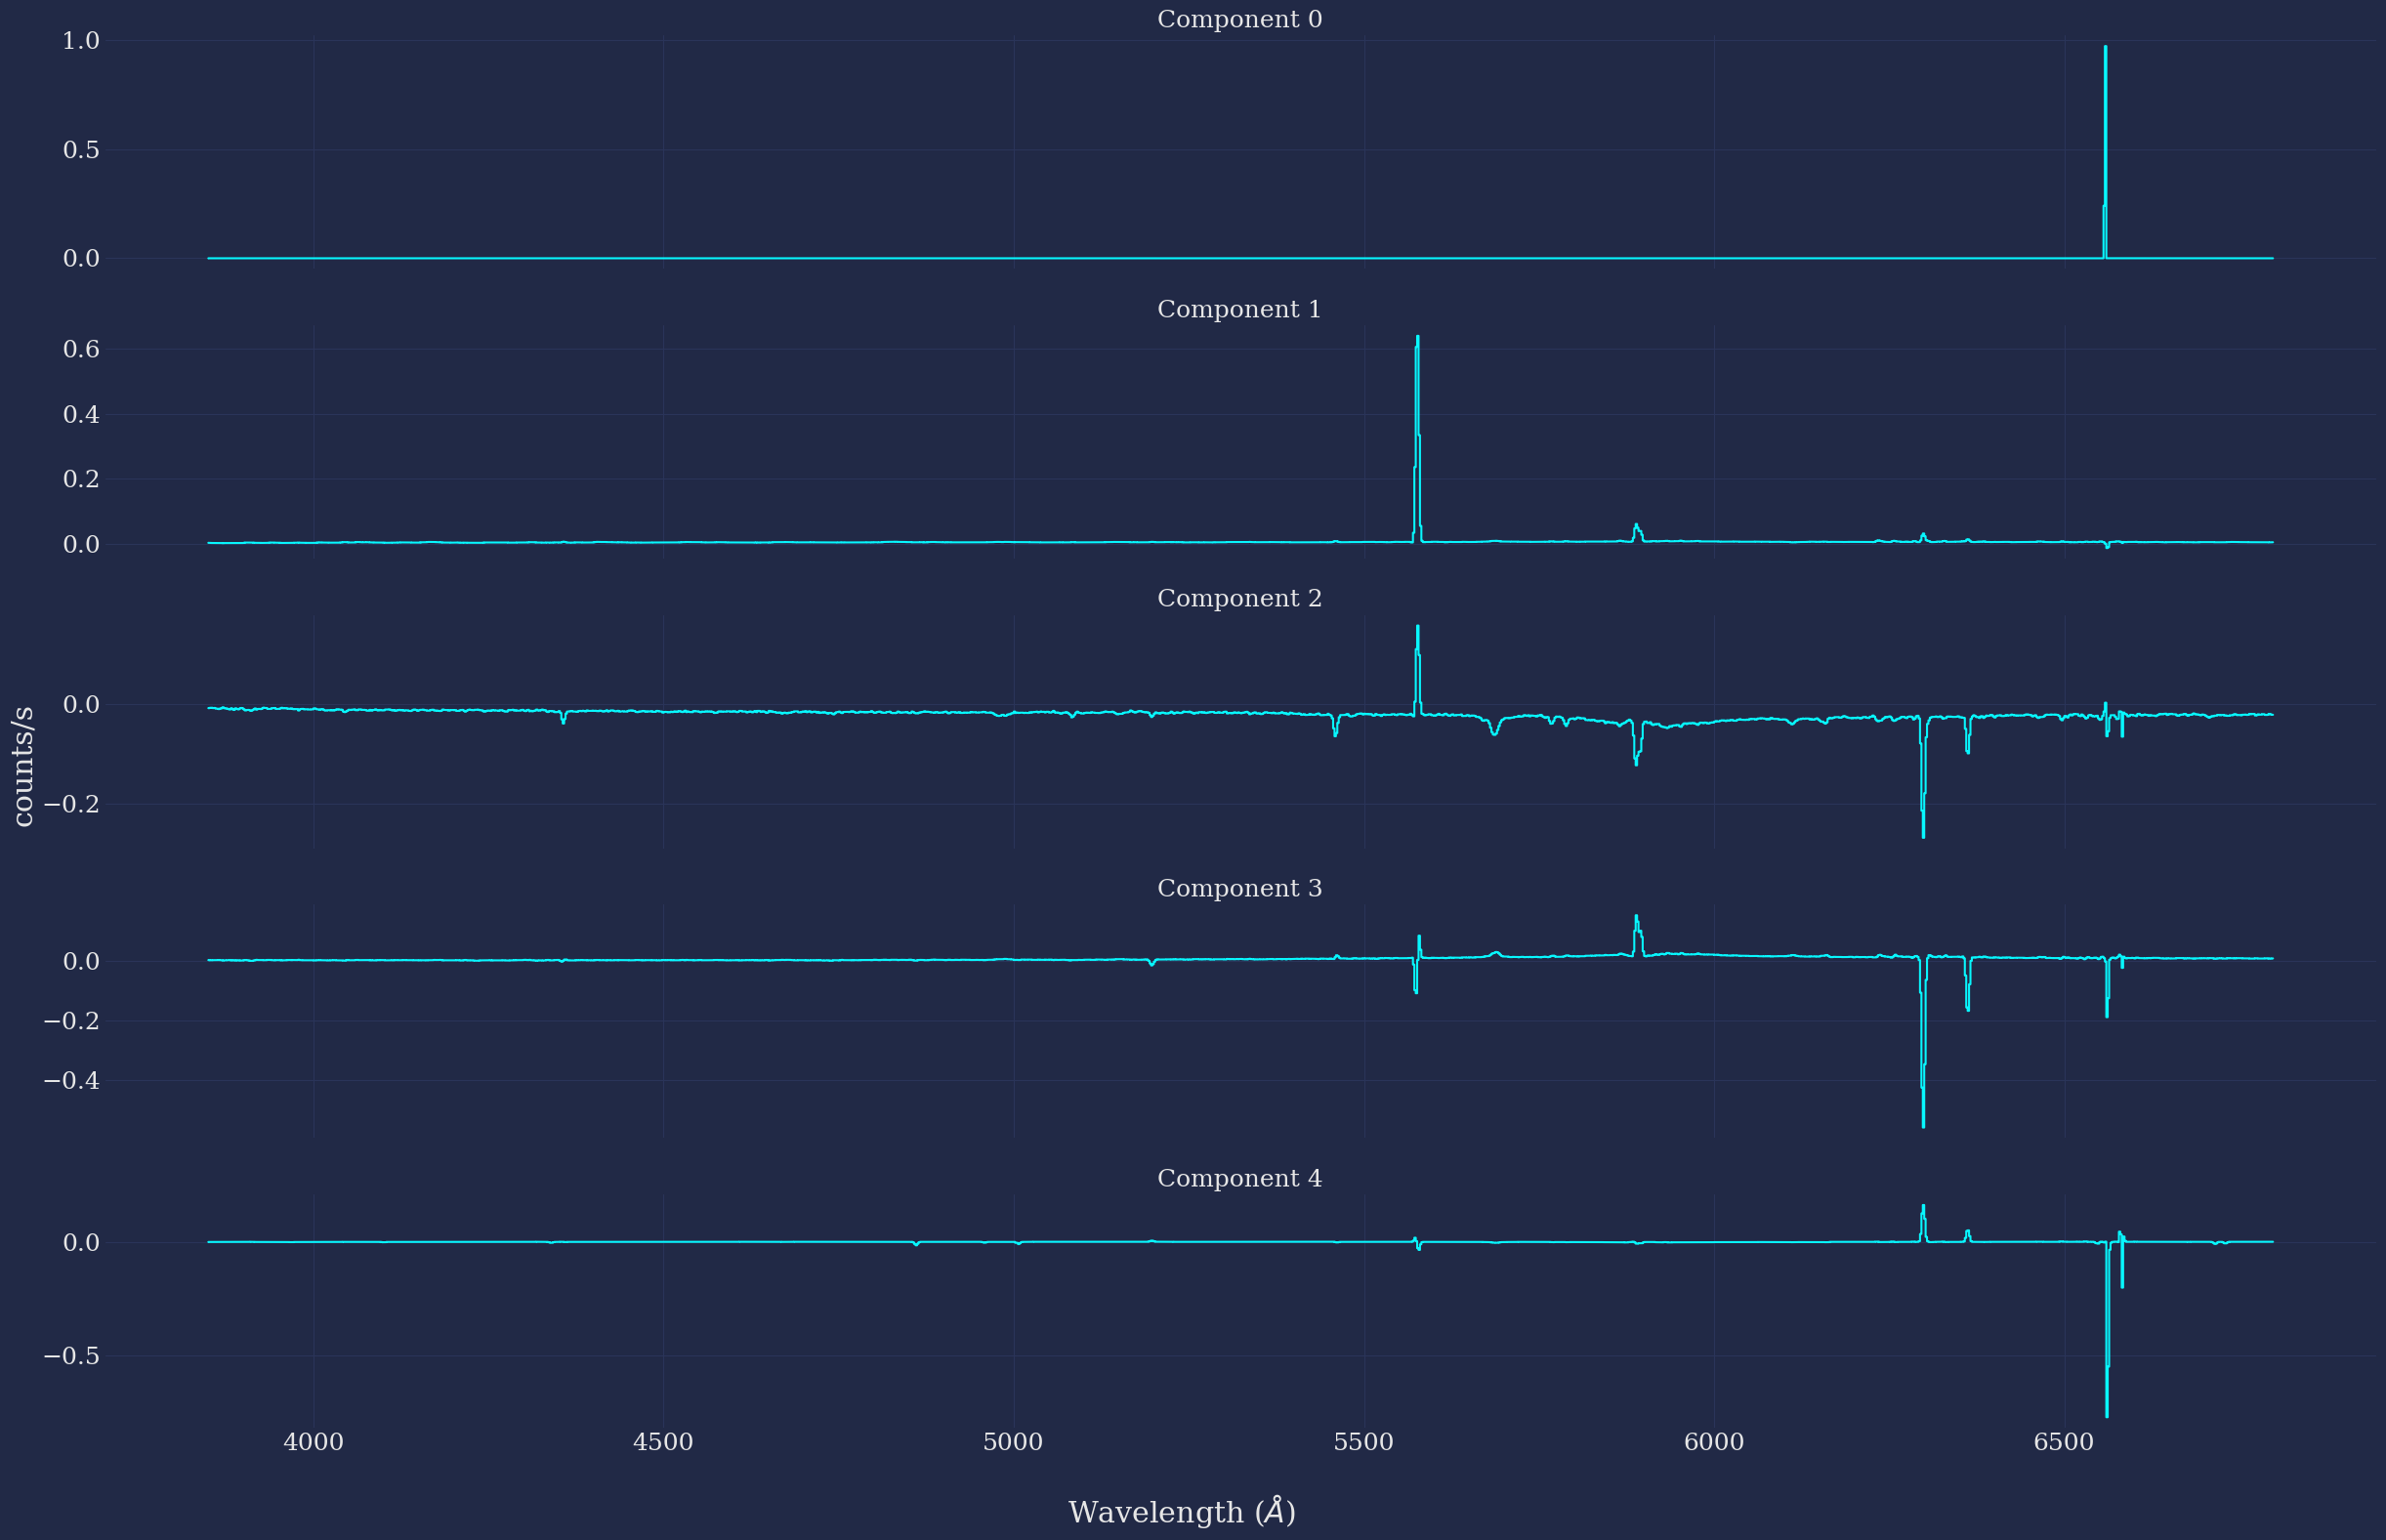

In [125]:
fig, axs = plt.subplots(5, 1, figsize=[25,16], sharex=True)
for i, ax in enumerate(axs.flat):
    ax.step(new_disp_grid, pca.components_[i])
    ax.set_title(f"Component {i}")
    #ax.set_ylabel("counts/s")
    #ax.set_xlabel("Wavelength ($\AA$)")
    ax.set_ylabel("")
    ax.set_xlabel("")
    #if not ax.is_last_row():
        #ax.set_xticklabels([])
        #ax.set_xlabel("")
fig.supxlabel("Wavelength ($\AA$)")
fig.supylabel("counts/s")
fig.tight_layout()
plt.savefig("pca.pdf")
plt.show()

In [94]:
components[:, 1].std()

2.7063080541982942

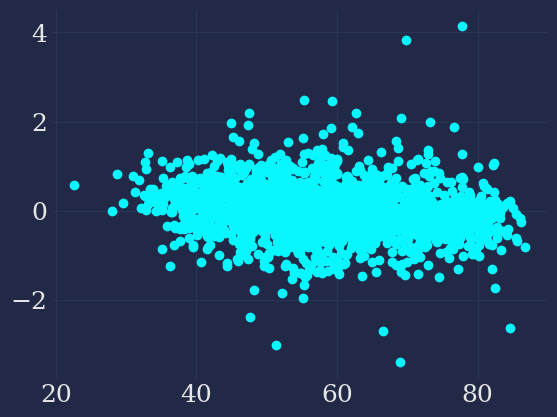

In [126]:
plt.figure()
plt.scatter(moonfree['alt'], components[:, 7])
plt.show()

In [25]:
np.argmax(components[:, 0])

998

In [23]:
moonfree.iloc[998]

file         data/2010.1001/skysub_hecto_spec_2010_1_comb.fits
ut                                         2010-10-01T03:32:18
alt                                                       52.7
az                                                       23.63
moon_alt                                                -27.28
moon_az                                                   34.6
moon_ill                                                    50
disperser                                              270_gpm
Name: 1648, dtype: object

In [127]:
resid = fluxes - filtered

/var/folders/vx/hkwj3_y50fgbdckq7hcv_p000000gn/T/ipykernel_74823/1715648520.py:22: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True, color='w', alpha=0.4)


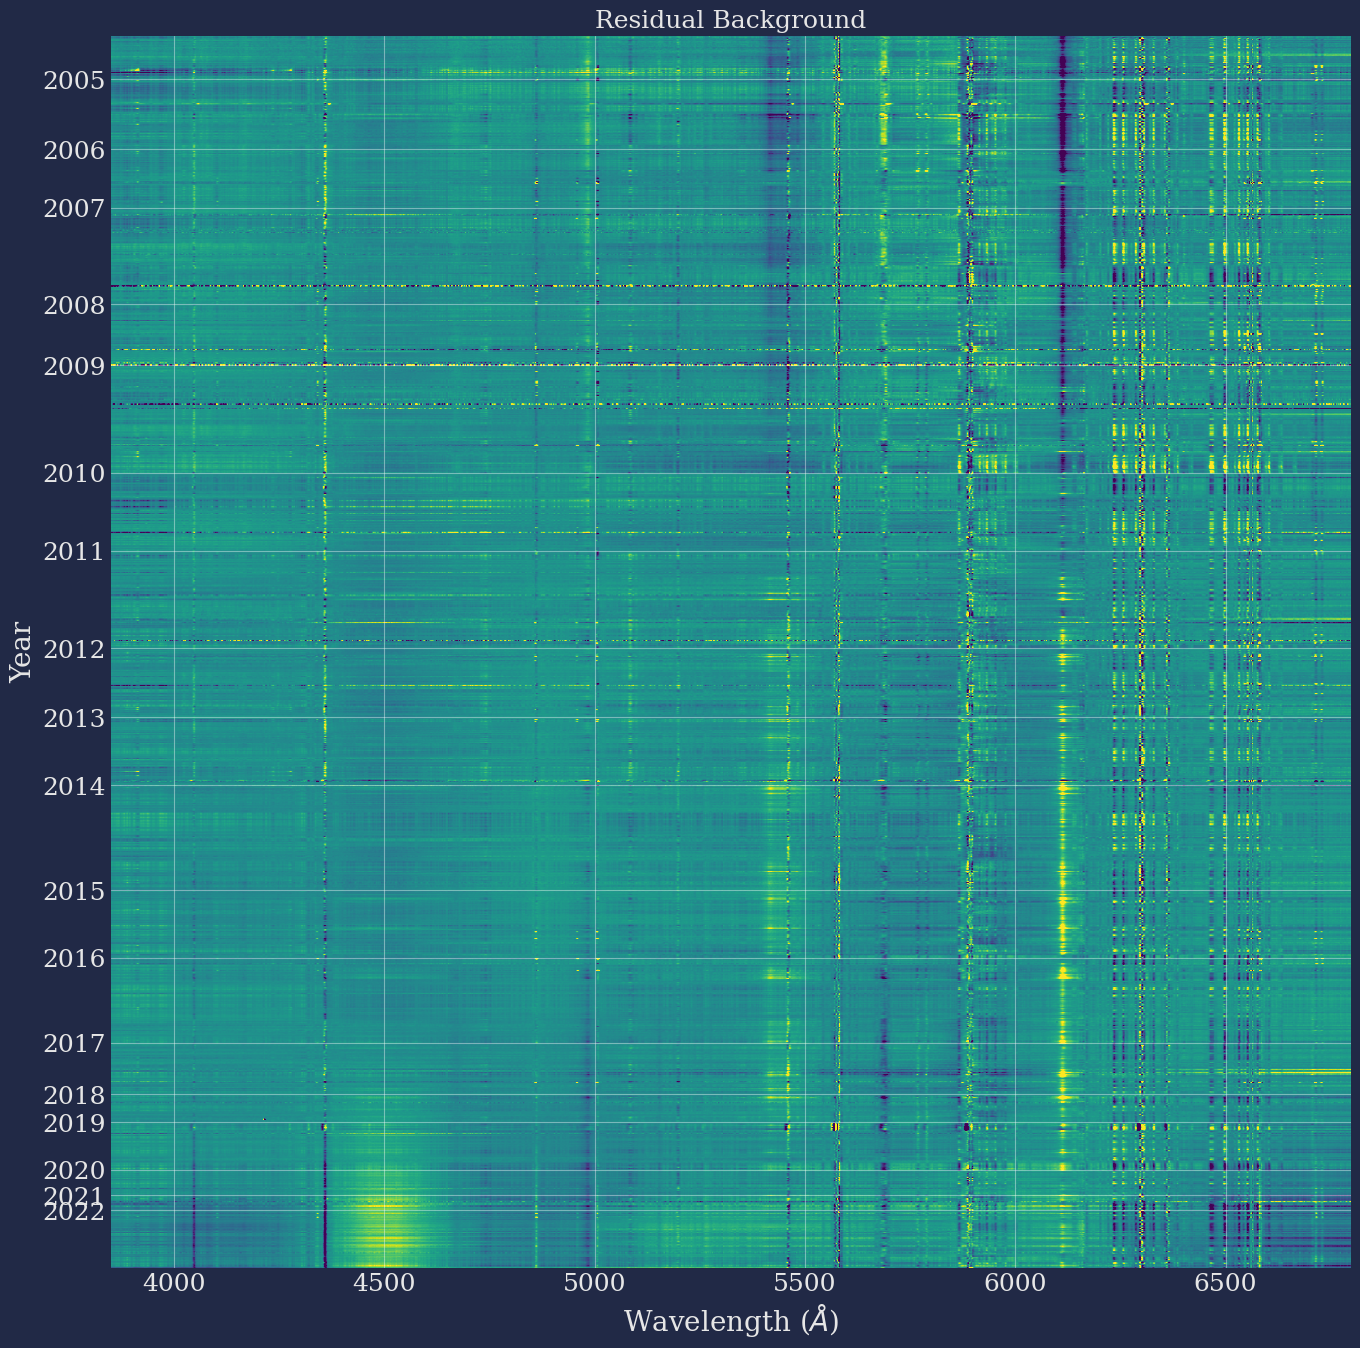

In [189]:
ut = Time(list(moonfree['ut'].values), format='isot', scale='utc')
years = pd.DatetimeIndex(moonfree['ut']).year
ydiff = np.diff(years.values)
transitions = np.where(ydiff == 1)[0]
label_yrs = list(range(2005, 2023))
rms = resid.std()
fig, ax = plt.subplots(figsize=[16,16])
extent = (
    new_disp_grid[0].value,
    new_disp_grid[-1].value,
    len(ut),
    0
)
cm = ax.imshow(resid, vmin=-3*rms, vmax=3*rms, extent=extent, aspect='auto', cmap='viridis')
ax.set_xlabel("Wavelength ($\AA$)")
ax.set_ylabel("Year")
ax.set_title("Residual Background")
ax.grid(b=True, color='w', alpha=0.4)
ax.set_yticks(transitions)
ax.set_yticklabels(label_yrs)
#cb = fig.colorbar(cm, ax=ax)
#cb.set_label("Counts/sec")
plt.savefig("resid.pdf")
plt.show()

/var/folders/vx/hkwj3_y50fgbdckq7hcv_p000000gn/T/ipykernel_74823/1354146319.py:18: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True, color='w', alpha=0.4)


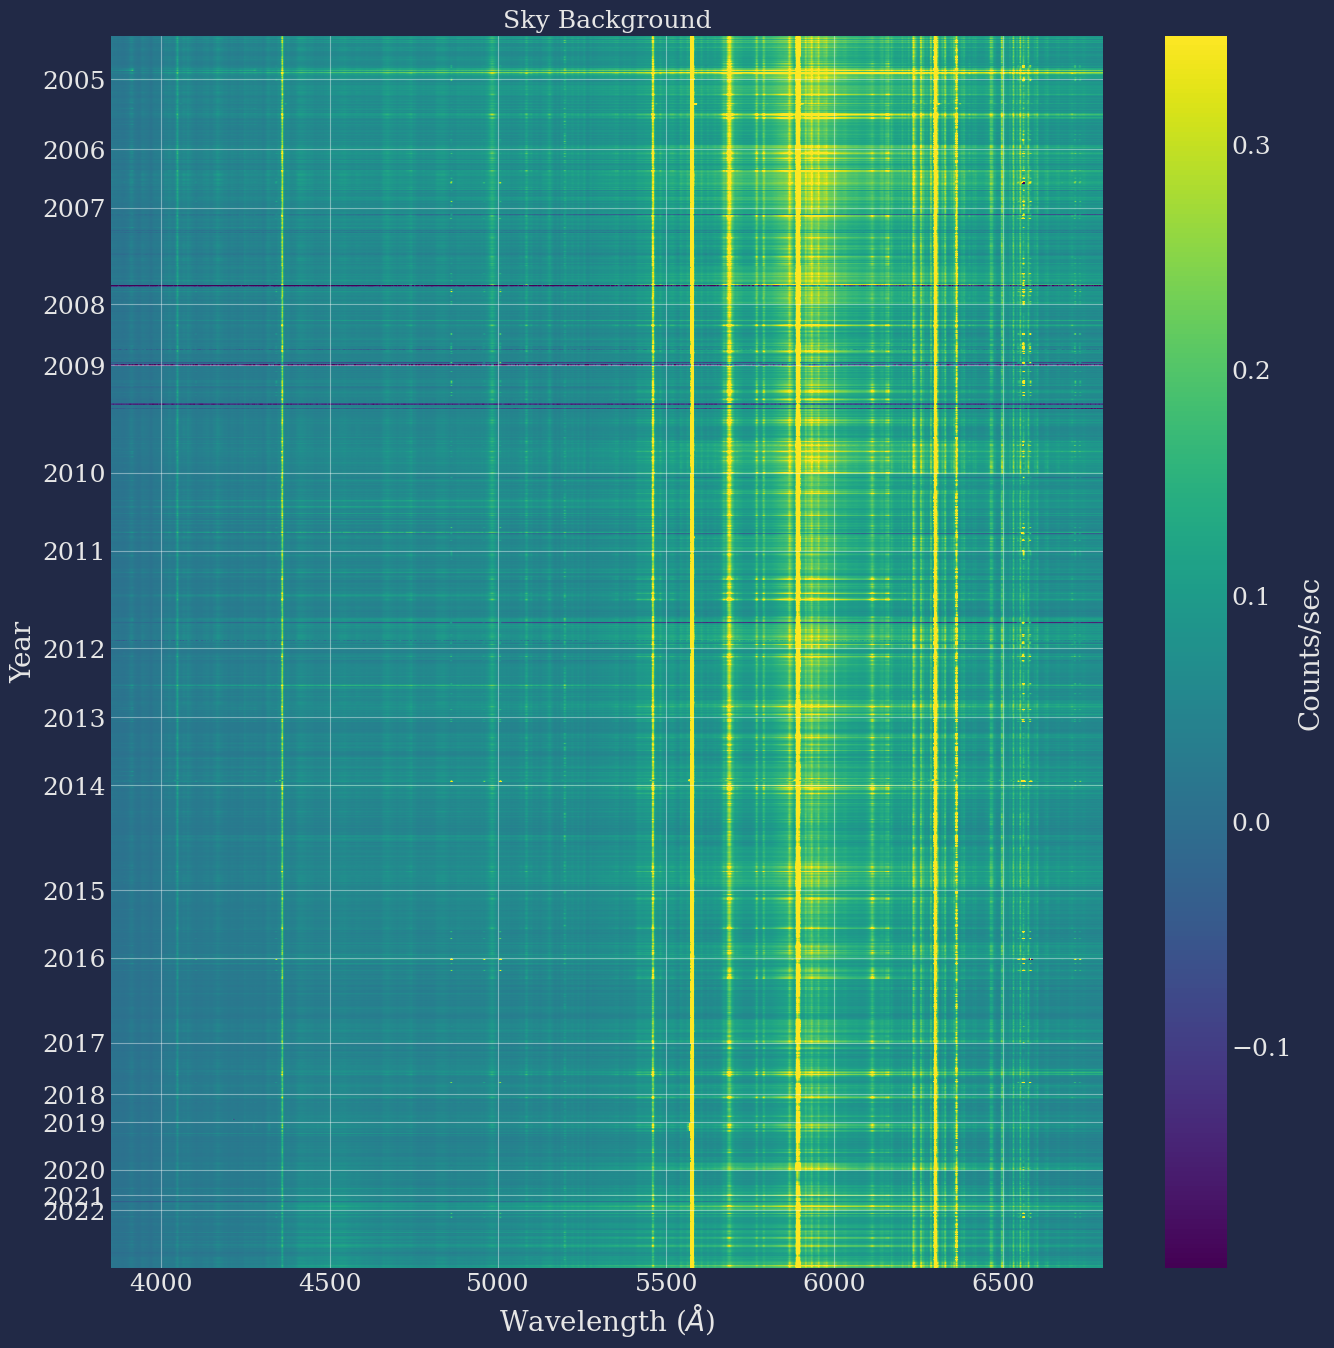

In [190]:
ut = Time(list(moonfree['ut'].values), format='isot', scale='utc')
rms = fluxes.std()
fig, ax = plt.subplots(figsize=[16,16])
extent = (
    new_disp_grid[0].value,
    new_disp_grid[-1].value,
    len(ut),
    0
)

norm = ImageNormalize(fluxes, interval=ZScaleInterval()) #, stretch=SqrtStretch())
cm = ax.imshow(fluxes, extent=extent, aspect='auto', cmap='viridis', norm=norm)
ax.set_yticks(transitions)
ax.set_yticklabels(label_yrs)
ax.set_xlabel("Wavelength ($\AA$)")
ax.set_ylabel("Year")
ax.set_title("Sky Background")
ax.grid(b=True, color='w', alpha=0.4)
cb = fig.colorbar(cm, ax=ax)
cb.set_label("Counts/sec")
plt.savefig("sky_flux.pdf")
plt.show()

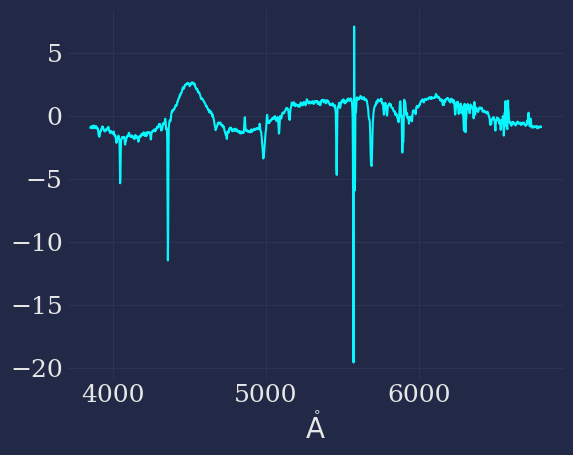

In [74]:
early = resid[:200, :].sum(axis=0)
late = resid[-200:, :].sum(axis=0)
diff = late - early
plt.plot(new_disp_grid, late)
plt.show()

In [36]:
new_disp_grid[1132].value

6114.0

In [152]:
ut[-1]

<Time object: scale='utc' format='isot' value=2022-11-29T09:40:41.000>

In [38]:
new_disp_grid[919]

<Quantity 5688. Angstrom>

In [39]:
new_disp_grid[567]

<Quantity 4984. Angstrom>

In [134]:
fits.writeto("resid.fits", resid, overwrite=True)

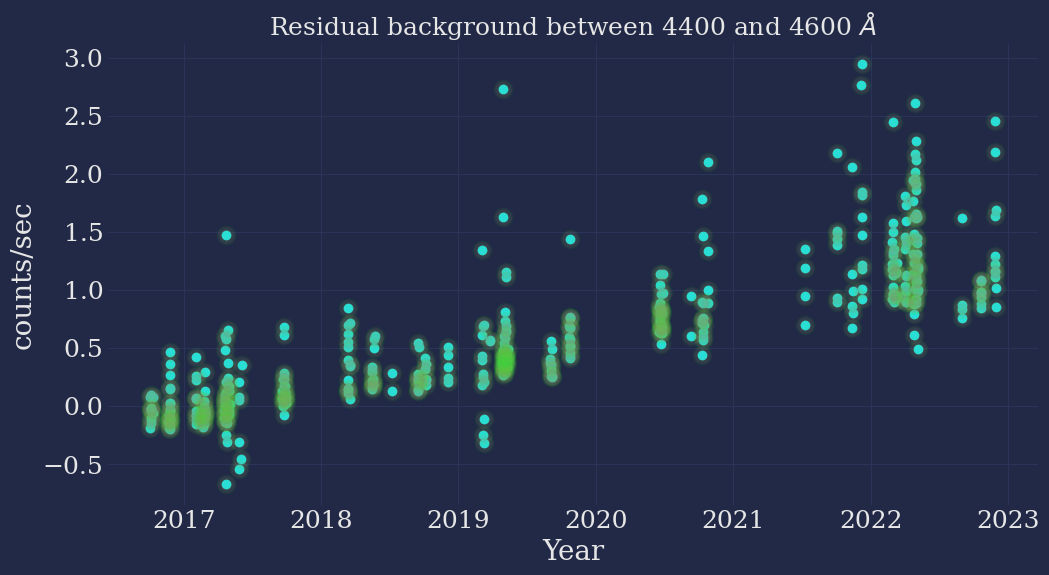

In [156]:
led = np.sum(resid[:, 275:375], axis=1)
plt.figure(figsize=[12,6])
plt.scatter(ut.to_datetime()[1800:], led[1800:])
plt.xlabel("Year")
plt.ylabel("counts/sec")
plt.title("Residual background between 4400 and 4600 $\AA$")
mplcyberpunk.make_scatter_glow()
plt.savefig("led_2017_2022.pdf")
plt.show()

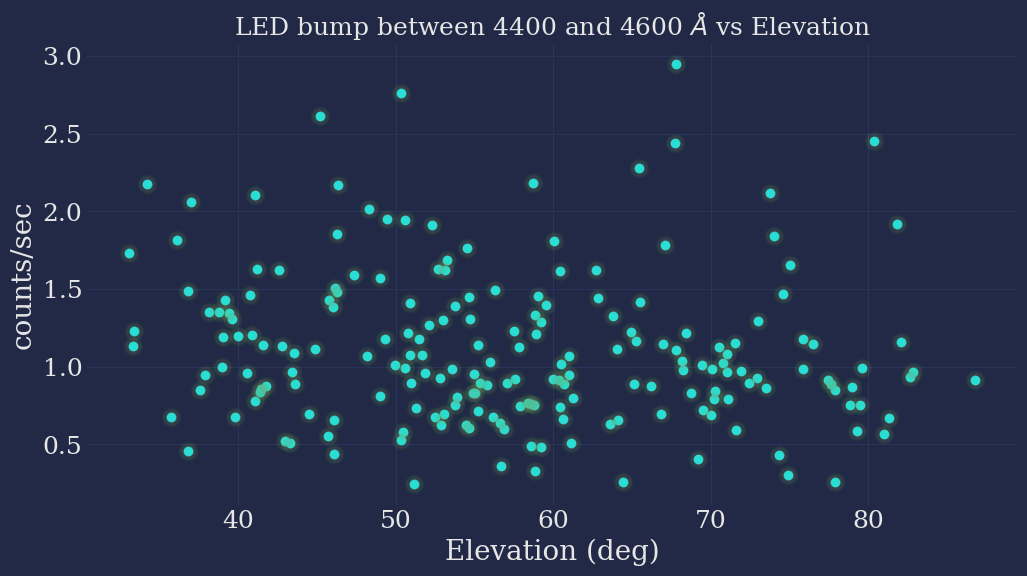

In [175]:
plt.figure(figsize=[12,6])
plt.scatter(moonfree['alt'].values[-200:], led[-200:])
plt.xlabel("Elevation (deg)")
plt.ylabel("counts/sec")
plt.title("LED bump between 4400 and 4600 $\AA$ vs Elevation")
mplcyberpunk.make_scatter_glow()
plt.savefig("led_el.pdf")
plt.show()

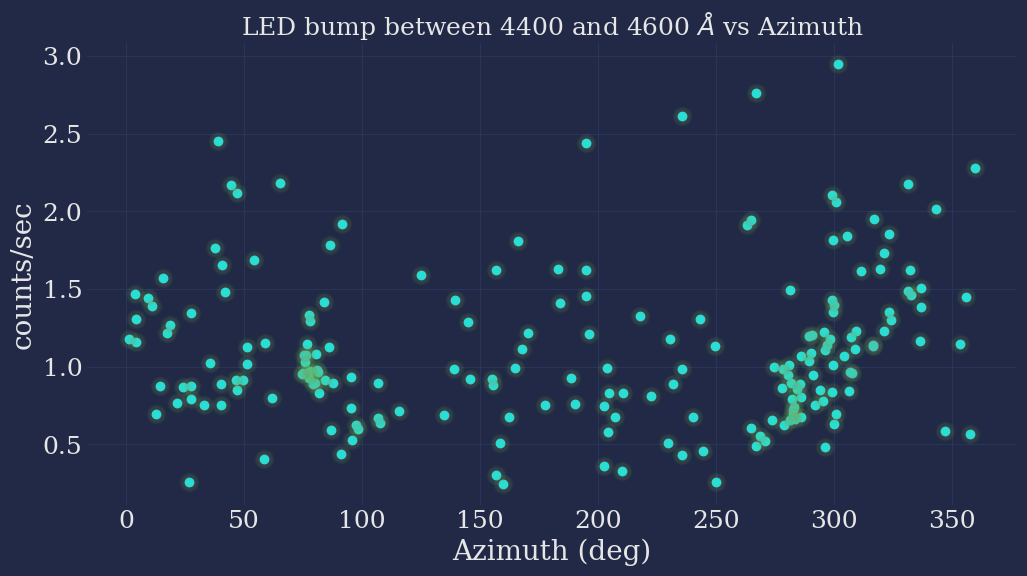

In [174]:
plt.figure(figsize=[12,6])
plt.scatter(moonfree['az'].values[-200:], led[-200:])
plt.xlabel("Azimuth (deg)")
plt.ylabel("counts/sec")
plt.title("LED bump between 4400 and 4600 $\AA$ vs Azimuth")
mplcyberpunk.make_scatter_glow()
plt.savefig("led_az.pdf")
plt.show()

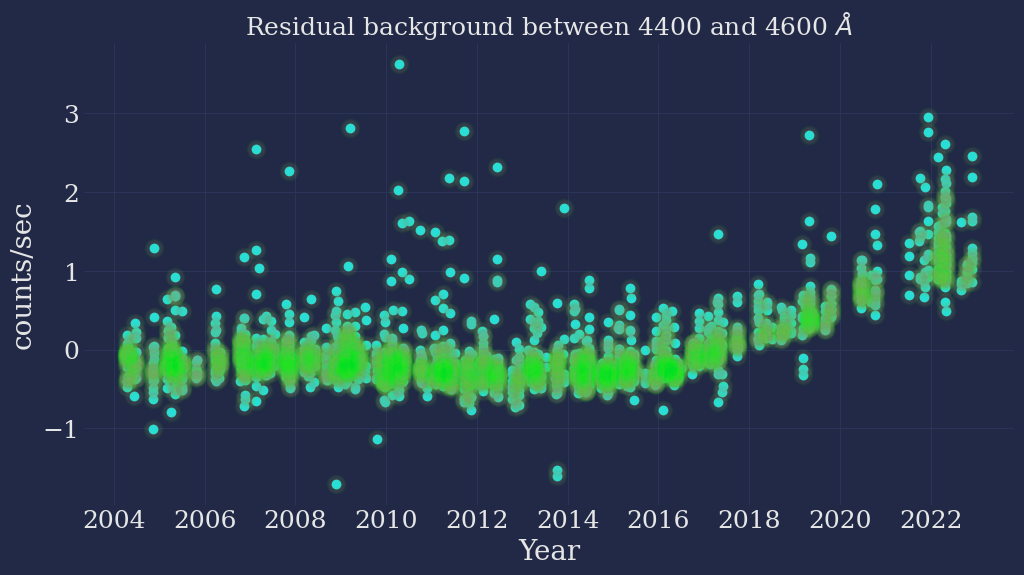

In [158]:
led = np.sum(resid[:, 275:375], axis=1)
plt.figure(figsize=[12,6])
plt.scatter(ut.to_datetime(), led)
plt.xlabel("Year")
plt.ylabel("counts/sec")
plt.title("Residual background between 4400 and 4600 $\AA$")
mplcyberpunk.make_scatter_glow()
plt.savefig("led.pdf")
plt.show()

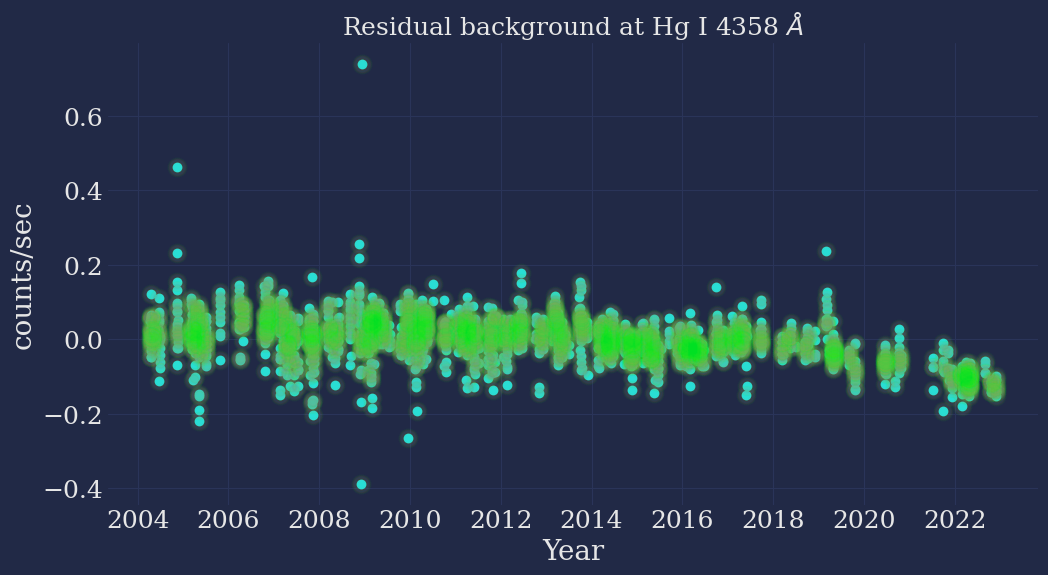

In [149]:
hg_4358 = np.sum(resid[:, 254:258], axis=1)
plt.figure(figsize=[12,6])
plt.scatter(ut.to_datetime(), hg_4358)
plt.xlabel("Year")
plt.ylabel("counts/sec")
plt.title("Residual background at Hg I 4358 $\AA$")
mplcyberpunk.make_scatter_glow()
plt.savefig("hg_4358.pdf")
plt.show()

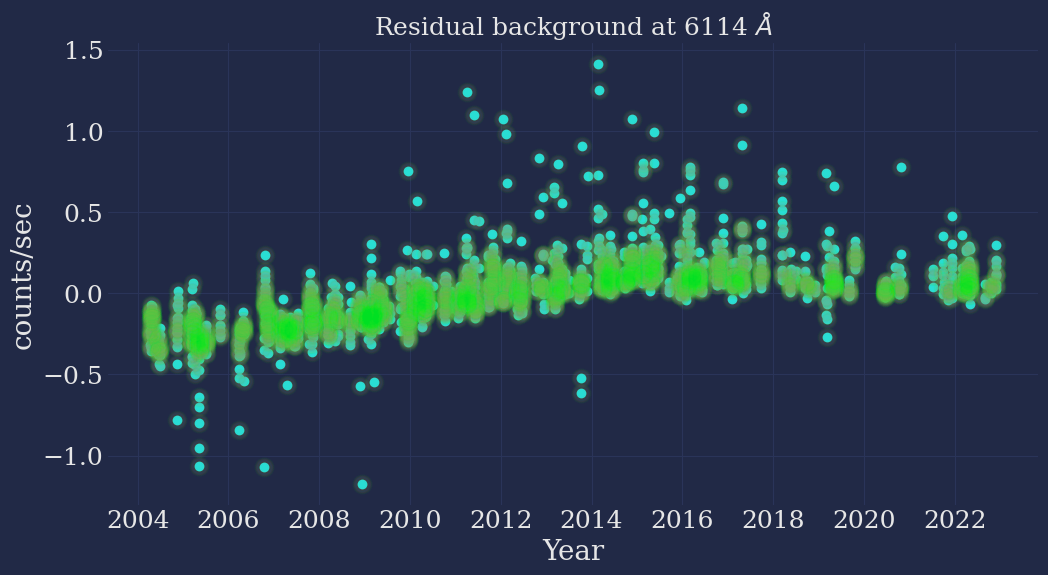

In [150]:
fl_6114 = np.sum(resid[:, 1126:1136], axis=1)
plt.figure(figsize=[12,6])
plt.scatter(ut.to_datetime(), fl_6114)
plt.xlabel("Year")
plt.ylabel("counts/sec")
plt.title("Residual background at 6114 $\AA$")
mplcyberpunk.make_scatter_glow()
plt.savefig("fl_6614.pdf")
plt.show()

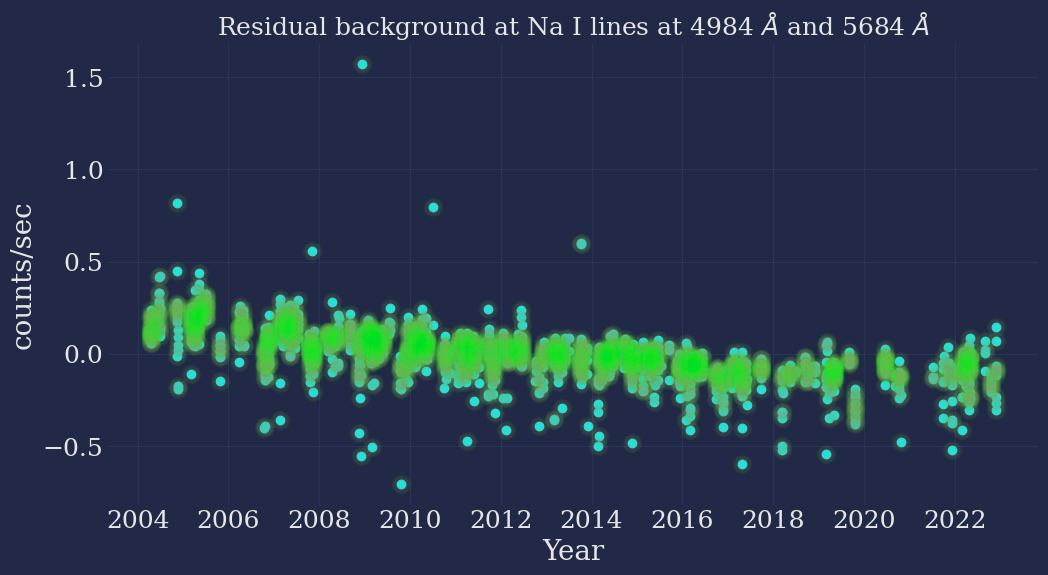

In [151]:
nai_4984 = np.sum(resid[:, 562:571], axis=1)
nai_5684 = np.sum(resid[:, 915:922], axis=1)
nai = nai_4984 + nai_5684
plt.figure(figsize=[12,6])
plt.scatter(ut.to_datetime(), nai)
plt.xlabel("Year")
plt.ylabel("counts/sec")
plt.title("Residual background at Na I lines at 4984 $\AA$ and 5684 $\AA$")
mplcyberpunk.make_scatter_glow()
plt.savefig("nai.pdf")
plt.show()

In [163]:
moonfree['az'].values.max()

359.98

In [176]:
moonfree['ut']

1       2004-04-13T05:53:13
2       2004-04-13T08:25:25
4       2004-04-14T05:11:49
5       2004-04-14T07:00:59
6       2004-04-15T05:48:01
               ...         
4311    2022-11-28T08:02:53
4312    2022-11-28T10:00:40
4313    2022-11-28T06:02:24
4315    2022-11-29T12:19:52
4316    2022-11-29T09:40:41
Name: ut, Length: 2241, dtype: object

In [182]:
y = pd.DatetimeIndex(moonfree['ut']).year
d = np.diff(y.values)
np.where(d == 1)

(array([  79,  207,  313,  489,  599,  795,  937, 1114, 1240, 1363, 1554,
        1677, 1832, 1925, 1977, 2063, 2109, 2136]),)